In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Homework 3

For this homework, you will be working extensively in tensorflow. It is suggested that you spin up a Google Cloud VM with a GPU attached. Remember, instructions for doing so are found in Homework 0.

### Part 1: Homework 2, but on tensorflow
### Part 2: DNN on MNIST and CIFAR10
### Part 3: VGG on MNIST and CIFAR10
### (Optional) Part 4, getting state of the art (#SOTA)


# Part 1
You don't have to repeat everything in homework 2, but rather pick one set of two features that worked well for you last homework, and implement logistic regression using tensorflow without using keras (you will practice using keras in parts 2 and 3). In other words, using tensorflow operations, please create a scalar-value loss function and let tensorflow create the training operation for logistic regression, which automatically computes the gradients and updates the weight parameters. Note that the logistic loss is a special case of the softmax cross entropy loss that you've seen when classifying MNIST.

In [ ]:
# Import datasets
%matplotlib inline

from sklearn import datasets
import matplotlib.pyplot as plt
digits = datasets.load_digits()

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

number_a = 0
number_b = 3

digit_a_indexes = np.where(digits.target==number_a) 
digit_b_indexes = np.where(digits.target==number_b)
targets = np.concatenate((digits.target[digit_a_indexes], digits.target[digit_b_indexes]))
images = np.concatenate((digits.images[digit_a_indexes], digits.images[digit_b_indexes]))
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)

In [ ]:
def compute_features(vector):
    image = vector.reshape(8, 8) # get back original image shape
    def compute_feature_a(image):
        return np.mean(image*np.rot90(image, k = 2))
    def compute_feature_b(image):
        return np.mean(image)
    return compute_feature_a(image), compute_feature_b(image)

# Apply and plot your features
# for x train dataset
X_features_train = np.apply_along_axis(compute_features, 1, X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_features_a = X_features_train[np.where(y_train==number_a)]
X_features_b = X_features_train[np.where(y_train==number_b)]

# for x test dataset
X_features_test = np.apply_along_axis(compute_features, 1, X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
X_features_a_test = X_features_test[np.where(y_test==number_a)]
X_features_b_test = X_features_test[np.where(y_test==number_b)]


# for y train
y_train_label = np.copy(y_train)
y_train_label[y_train == number_a] = -1
y_train_label[y_train == number_b] = 1

# for y test
y_test_label = np.copy(y_test)
y_test_label[y_test == number_a] = -1
y_test_label[y_test == number_b] = 1

In [ ]:
# cast as a float32; in general, you will work with float32 inputs:
X_features_train = X_features_train.astype(np.float32)
X_features_test = X_features_test.astype(np.float32)
print(X_features_train.shape)
print(X_features_test.shape)

In [ ]:
y_train_label = y_train_label.astype(np.float32)
y_test_label = y_test_label.astype(np.float32)
print(y_train_label.shape)
print(y_test_label.shape)

In [ ]:
# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.float32, [None, 2], name='input_features')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
# batch_size = 2

# # create a tf dataset, from which we can generate batches
# dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
# dataset = dataset.repeat()
# dataset = dataset.batch(batch_size)
# batch_generator = dataset.make_initializable_iterator()
# X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

In [ ]:
net = X_batch
# fully connected layers:
# net = tf.layers.flatten(net)
# net = tf.layers.dense(net, units=512, activation=tf.nn.relu) # was 256
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=2) # was 10

logits = net
weights = np.random.rand(2)
features = np.copy(X_features_train)
labels = np.copy(y_test_label)

loss = (0.5*np.matmul((labels - np.matmul(features,weights)).transpose(), (labels - np.matmul(features,weights))))/np.size(labels)
# loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=2), logits=logits) # original depth = 10
# loss = tf.losses.log_loss(onehot_labels=tf.one_hot(y_batch, depth=2), logits=logits) # original depth = 10

In [ ]:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.01).minimize(loss)

In [ ]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

In [ ]:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_features_train, y_train_or_test: y_train_label})
for i in range(1000):
    _, loss_i = sess.run([train_op, loss])
    if i%100 == 0:
        print(loss_i)

In [ ]:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_features_test, y_train_or_test: y_test_label})
correct = 0
total = 0
for i in range(100):
    prediction, truth = sess.run([logits, y_batch])
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print(acc)

# Part 2:  DNN on MNIST and CIFAR10

In our lab, you guys saw how to work with the MNIST dataset to perform image classification. We can attempt the MNIST classification problem with just fully connected layers. This means we will be optimizing for non-banded matrices (no convolutions).

1. Calcualte the number of weight parameters you are optimizing for 1, 2 and 3 different fully connected layers (the total size of each layer is up to you).
2. What is the max layer depth you can go before training loss does not converge? You can usually tell that something is not converging by examining the training loss vs. iteration curve.
3. How does the number of parameters relate to the training loss and validation/test loss? Try to get a few data points to speak to this question.
3. Keeping the maximum number of parameters possible while still maintaining convergence (i.e., a good training and validation/test loss), what happens when you swap the activation function to `tanh` instead of `relu`? How about `sigmoid`?
4. After exploring the above, train a DNN model with the combination of hyperparameters that you believe will work best on MNIST.
5. Using the same architecture, try training a DNN model on more difficult dataset such as Fashion MNIST or CIFAR10/100. Example download instructions are shown in the next problem.

### Must haves
1. Make a curve of the final validation/test loss of your DNN after the loss plateaus as a function of the number of weight parameters used (final loss versus # parameters used). Note that you might see something like the curve below for a low number of parameters, but as the number of parameters increases, it will not look like this plot. 
2. On the same figure, make the same curve as above, but use different activation functions in your architecture.
3. Plot a point corresponding to your crafted DNN archiecture for question 4.
4. Repeat 1-3 for CIFAR10

The curves when reasonable # params are used look like the below
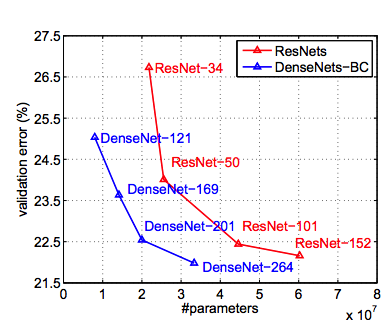

In [1]:
parameters = []
train_error = []
test_error = []

Training data shape (60000, 28, 28, 1)


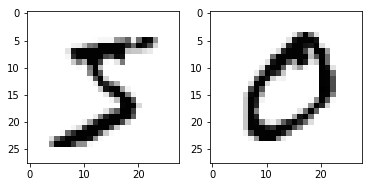

In [2]:
import tensorflow as tf
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data() #load dataset
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(28, 28), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(28, 28), cmap=plt.cm.Greys);

In [3]:
n = 15 # number of test
for i in range(n):
    model = tf.keras.Sequential([])
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))
    for j in range(i):
        model.add(tf.keras.layers.Dense(100, activation='relu'))
    for k in range(i):
        model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    parameters.append(model.count_params())  #count parameters for you

    model.compile(optimizer=tf.train.AdamOptimizer(0.005),
                  loss='categorical_crossentropy', #10 classes for output
                  metrics=['accuracy']) # add mae: mean average error
    model.summary()
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3)
    # tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format('model_name'))
    hist = model.fit(X_train, y_train,
                         batch_size=64,
                         epochs=5,
                         verbose=1,
                         validation_data=(X_val, y_val),
                         callbacks=[early_stop])
    train_error.append(100*(1-max(hist.history['acc'])))
    print('train_error: ', train_error)
    test_error.append(100*(1-max(hist.history['val_acc'])))
    print('test_error: ', test_error)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 35us/step - loss: 11.5011 - acc: 0.2860 - val_loss: 11.2560 - val_acc: 0.3014
Epoch 2/5
60000/60000 [==============================] - 2s 28us/step - loss: 11.2682 - acc: 0.3008 - val_loss: 11.1585 - val_acc: 0.3077
Epoch 3/5
60000/60000 [==============================] - 2s 28us/step - loss: 11.2578 - acc: 0.3014 - val_loss: 11.1988 - val_acc: 0.3051
Epoch 4/5
60000/60000 [==============================] - 2s 28us/step - 

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 87us/step - loss: 0.5214 - acc: 0.8704 - val_loss: 0.2725 - val_acc: 0.9282
Epoch 2/5
60000/60000 [==============================] - 4s 68us/step - loss: 0.2553 - acc: 0.9363 - val_loss: 0.2548 - val_acc: 0.9355
Epoch 3/5
60000/60000 [==============================] - 5s 81us/step - loss: 0.2279 - acc: 0.9461 - val_loss: 0.2126 - val_acc: 0.9505
Epoch 4/5
60000/60000 [==============================] - 4s 71us/step - loss: 0.2247 - acc: 0.9481 - val_loss: 0.2254 - val_acc: 0.9482
Epoch 5/5
60000/60000 [==============================] - 4s 68us/step - loss: 0.2187 - acc: 0.9482 - val_loss: 0.4387 - val_acc: 0.8508
train_error:  [69.48, 89.89, 88.75833333333334, 88.76333333333332, 5.174999999999996]
test_error:  [69.23, 89.91, 88.64999999999999, 88.64999999999999, 4.949999999999999]
_________________________________________________________________
Layer (type)                 Outp

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 138us/step - loss: 0.6717 - acc: 0.7853 - val_loss: 0.4036 - val_acc: 0.9073
Epoch 2/5
60000/60000 [==============================] - 6s 105us/step - loss: 1.0197 - acc: 0.6789 - val_loss: 2.2740 - val_acc: 0.1267
Epoch 3/5
60000/60000 [==============================] - 6s 105us/step - loss: 2.4770 - acc: 0.1193 - val_loss: 2.3017 - val_acc: 0.1028
Epoch 4/5
60000/60000 [==============================] - 6s 104us/step - loss: 2.3018 - acc: 0.1113 - val_loss: 2.3011 - val_acc: 0.1135
train_error:  [69.48, 89.89, 88.75833333333334, 88.76333333333332, 5.174999999999996, 6.164999999999998, 16.77833333333333, 21.471666666666668]
test_error:  [69.23, 89.91, 88.64999999999999, 88.64999999999999, 4.949999999999999, 6.240000000000001, 12.719999999999999, 9.27]
_________________________________________________________________
Layer (type)                 Output Shape              Param #

train_error:  [69.48, 89.89, 88.75833333333334, 88.76333333333332, 5.174999999999996, 6.164999999999998, 16.77833333333333, 21.471666666666668, 30.801666666666673, 26.775000000000006]
test_error:  [69.23, 89.91, 88.64999999999999, 88.64999999999999, 4.949999999999999, 6.240000000000001, 12.719999999999999, 9.27, 25.790000000000003, 22.199999999999996]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_101 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_102 (Dense)            (None, 100)               10100     
____________________________________________________

60000/60000 [==============================] - 13s 208us/step - loss: 1.4733 - acc: 0.5457 - val_loss: 1.1263 - val_acc: 0.6270
Epoch 2/5
60000/60000 [==============================] - 9s 154us/step - loss: 1.0390 - acc: 0.6464 - val_loss: 1.3618 - val_acc: 0.5338
Epoch 3/5
60000/60000 [==============================] - 9s 152us/step - loss: 1.2024 - acc: 0.5922 - val_loss: 0.8975 - val_acc: 0.6923
Epoch 4/5
60000/60000 [==============================] - 9s 158us/step - loss: 12.3865 - acc: 0.1938 - val_loss: 14.2887 - val_acc: 0.1135
Epoch 5/5
60000/60000 [==============================] - 9s 156us/step - loss: 14.3070 - acc: 0.1124 - val_loss: 14.2887 - val_acc: 0.1135
train_error:  [69.48, 89.89, 88.75833333333334, 88.76333333333332, 5.174999999999996, 6.164999999999998, 16.77833333333333, 21.471666666666668, 30.801666666666673, 26.775000000000006, 34.145, 35.36166666666667]
test_error:  [69.23, 89.91, 88.64999999999999, 88.64999999999999, 4.949999999999999, 6.240000000000001, 12.71

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 16s 264us/step - loss: 1.2553 - acc: 0.5309 - val_loss: 0.8293 - val_acc: 0.7306
Epoch 2/5
60000/60000 [==============================] - 11s 186us/step - loss: 1.0008 - acc: 0.6525 - val_loss: 1.1816 - val_acc: 0.5415
Epoch 3/5
60000/60000 [==============================] - 11s 189us/step - loss: 1.1784 - acc: 0.5720 - val_loss: 0.7670 - val_acc: 0.7735
Epoch 4/5
60000/60000 [==============================] - 11s 184us/step - loss: 0.9850 - acc: 0.6736 - val_loss: 0.8979 - val_acc: 0.7001
Epoch 5/5
60000/60000 [==============================] - 11s 184us/step - loss: 0.9125 - acc: 0.6940 - val_loss: 1.3130 - val_acc: 0.5098
train_error:  [69.48, 89.89, 88.75833333333334, 88.76333333333332, 5.174999999999996, 6.164999999999998, 16.77833333333333, 21.471666666666668, 30.801666666666673, 26.775000000000006, 34.145, 35.36166666666667, 88.76333333333332, 30.60166666666667]
test_error:

In [7]:
def plot_loss(parameters_list, train_errors_list, test_errors_list):
    ax = plt.subplot(111)
    ax.plot(parameters_list, train_errors_list,'r', label='train error')
    ax.plot(parameters_list, test_errors_list,'g', label='test error')
    ax.set(xlabel='# parameters', ylabel='validation error (%)')
    ax.legend()
    plt.title('Tanh Multiple Layers')
    plt.show()


parameter list:  [7850, 89610, 109810, 130010, 150210, 170410, 190610, 210810, 231010, 251210, 271410, 291610, 311810, 332010, 352210]
train_error:  [69.48, 89.89, 88.75833333333334, 88.76333333333332, 5.174999999999996, 6.164999999999998, 16.77833333333333, 21.471666666666668, 30.801666666666673, 26.775000000000006, 34.145, 35.36166666666667, 88.76333333333332, 30.60166666666667, 88.72666666666666]
test_error:  [69.23, 89.91, 88.64999999999999, 88.64999999999999, 4.949999999999999, 6.240000000000001, 12.719999999999999, 9.27, 25.790000000000003, 22.199999999999996, 34.0, 30.769999999999996, 88.64999999999999, 22.650000000000002, 88.64999999999999]


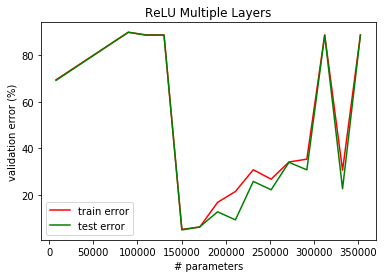

In [6]:
print('parameter list: ', parameters)
print('train_error: ', train_error)
print('test_error: ', test_error)
plot_loss(parameters, train_error, test_error)

In [ ]:
# tanh:

In [4]:
n = 15 # number of test
for i in range(n):
    model = tf.keras.Sequential([])
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))
    for j in range(i):
        model.add(tf.keras.layers.Dense(100, activation='tanh'))
    for k in range(i):
        model.add(tf.keras.layers.Dense(60, activation='tanh'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    parameters.append(model.count_params())  #count parameters for you

    model.compile(optimizer=tf.train.AdamOptimizer(0.001),
                  loss='categorical_crossentropy', #10 classes for output
                  metrics=['accuracy']) # add mae: mean average error
    model.summary()
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3)
    # tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format('model_name'))
    hist = model.fit(X_train, y_train,
                         batch_size=64,
                         epochs=15,
                         verbose=1,
                         validation_data=(X_val, y_val),
                         callbacks=[early_stop])
    train_error.append(100*(1-max(hist.history['acc'])))
    print('train_error: ', train_error)
    test_error.append(100*(1-max(hist.history['val_acc'])))
    print('test_error: ', test_error)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 2s 36us/step - loss: 6.9413 - acc: 0.5628 - val_loss: 4.9777 - val_acc: 0.6857
Epoch 2/15
60000/60000 [==============================] - 2s 27us/step - loss: 4.7359 - acc: 0.7015 - val_loss: 4.4802 - val_acc: 0.7185
Epoch 3/15
60000/60000 [==============================] - 2s 28us/step - loss: 4.5507 - acc: 0.7140 - val_loss: 4.4140 - val_acc: 0.7231
Epoch 4/15
60000/60000 [==============================] - 2s 28us/step - lo

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 4s 72us/step - loss: 0.5884 - acc: 0.8111 - val_loss: 0.4539 - val_acc: 0.8513
Epoch 2/15
60000/60000 [==============================] - 3s 55us/step - loss: 0.4337 - acc: 0.8609 - val_loss: 0.3892 - val_acc: 0.8726
Epoch 3/15
60000/60000 [==============================] - 3s 57us/step - loss: 0.3742 - acc: 0.8818 - val_loss: 0.3493 - val_acc: 0.8928
Epoch 4/15
60000/60000 [==============================] - 3s 53us/step - loss: 0.3503 - acc: 0.8881 - val_loss: 0.3348 - val_acc: 0.8916
Epoch 5/15
60000/60000 [==============================] - 3s 52us/step - loss: 0.3244 - acc: 0.8966 - val_loss: 0.2800 - val_acc: 0.9112
Epoch 6/15
60000/60000 [==============================] - 3s 54us/step - loss: 0.2990 - acc: 0.9057 - val_loss: 0.2894 - val_acc: 0.9093
Epoch 7/15
60000/60000 [==============================] - 3s 56us/step - loss: 0.3030 - acc: 0.9033 - val_loss: 0.2842 - val_acc

60000/60000 [==============================] - 4s 64us/step - loss: 0.3307 - acc: 0.8945 - val_loss: 0.3440 - val_acc: 0.8906
Epoch 9/15
60000/60000 [==============================] - 4s 66us/step - loss: 0.3381 - acc: 0.8923 - val_loss: 0.3310 - val_acc: 0.8989
Epoch 10/15
60000/60000 [==============================] - 4s 64us/step - loss: 0.3264 - acc: 0.8972 - val_loss: 0.3163 - val_acc: 0.9000
Epoch 11/15
60000/60000 [==============================] - 4s 65us/step - loss: 0.2955 - acc: 0.9083 - val_loss: 0.2752 - val_acc: 0.9189
Epoch 12/15
60000/60000 [==============================] - 4s 65us/step - loss: 0.2916 - acc: 0.9096 - val_loss: 0.2901 - val_acc: 0.9121
Epoch 13/15
60000/60000 [==============================] - 4s 61us/step - loss: 0.2837 - acc: 0.9114 - val_loss: 0.2716 - val_acc: 0.9193
Epoch 14/15
60000/60000 [==============================] - 4s 68us/step - loss: 0.2748 - acc: 0.9138 - val_loss: 0.2797 - val_acc: 0.9122
Epoch 15/15
60000/60000 [======================

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 7s 121us/step - loss: 0.6906 - acc: 0.7798 - val_loss: 0.5171 - val_acc: 0.8348
Epoch 2/15
60000/60000 [==============================] - 5s 86us/step - loss: 0.5170 - acc: 0.8377 - val_loss: 0.5303 - val_acc: 0.8295
Epoch 3/15
60000/60000 [==============================] - 6s 99us/step - loss: 0.4793 - acc: 0.8503 - val_loss: 0.4956 - val_acc: 0.8448
Epoch 4/15
60000/60000 [==============================] - 6s 101us/step - loss: 0.4596 - acc: 0.8551 - val_loss: 0.4113 - val_acc: 0.8721
Epoch 5/15
60000/60000 [==============================] - 6s 92us/step - loss: 0.4012 - acc: 0.8754 - val_loss: 0.3697 - val_acc: 0.8865
Epoch 6/15
60000/60000 [==============================] - 5s 90us/step - loss: 0.3914 - acc: 0.8791 - val_loss: 0.3570 - val_acc: 0.8910
Epoch 7/15
60000/60000 [==============================] - 5s 88us/step - loss: 0.3635 - acc: 0.8876 - val_loss: 0.3540 - val_a

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 9s 156us/step - loss: 0.7545 - acc: 0.7580 - val_loss: 0.5716 - val_acc: 0.8252
Epoch 2/15
60000/60000 [==============================] - 7s 113us/step - loss: 0.5648 - acc: 0.8250 - val_loss: 0.5091 - val_acc: 0.8460
Epoch 3/15
60000/60000 [==============================] - 7s 115us/step - loss: 0.4958 - acc: 0.8485 - val_loss: 0.5436 - val_acc: 0.8340
Epoch 4/15
60000/60000 [==============================] - 7s 118us/step - loss: 0.4816 - acc: 0.8550 - val_loss: 0.4246 - val_acc: 0.8757
Epoch 5/15
60000/60000 [==============================] - 7s 118us/step - loss: 0.4587 - acc: 0.8614 - val_loss: 0.4461 - val_acc: 0.8617
Epoch 6/15
60000/60000 [==============================] - 7s 120us/step - loss: 0.4488 - acc: 0.8646 - val_loss: 0.4109 - val_acc: 0.8816
Epoch 7/15
60000/60000 [==============================] - 7s 123us/step - loss: 0.4214 - acc: 0.8728 - val_loss: 0.3772 - 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_122 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_123 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_124 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_125 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_126 (Dense)            (None, 100)               10100     
__________

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 14s 231us/step - loss: 0.8696 - acc: 0.7251 - val_loss: 0.6248 - val_acc: 0.8099
Epoch 2/15
60000/60000 [==============================] - 10s 170us/step - loss: 0.6510 - acc: 0.8025 - val_loss: 0.7373 - val_acc: 0.7799
Epoch 3/15
60000/60000 [==============================] - 10s 166us/step - loss: 0.6093 - acc: 0.8156 - val_loss: 0.5676 - val_acc: 0.8310
Epoch 4/15
60000/60000 [==============================] - 10s 173us/step - loss: 0.5332 - acc: 0.8406 - val_loss: 0.4997 - val_acc: 0.8513
Epoch 5/15
60000/60000 [==============================] - 10s 168us/step - loss: 0.5207 - acc: 0.8499 - val_loss: 0.5636 - val_acc: 0.8360
Epoch 6/15
60000/60000 [==============================] - 10s 171us/step - loss: 0.5312 - acc: 0.8446 - val_loss: 0.5321 - val_acc: 0.8370
Epoch 7/15
60000/60000 [==============================] - 10s 174us/step - loss: 0.4980 - acc: 0.8571 - val_loss: 0.

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 18s 298us/step - loss: 0.9408 - acc: 0.6993 - val_loss: 0.8350 - val_acc: 0.7407
Epoch 2/15
60000/60000 [==============================] - 12s 204us/step - loss: 0.7716 - acc: 0.7706 - val_loss: 0.6878 - val_acc: 0.8070
Epoch 3/15
60000/60000 [==============================] - 12s 195us/step - loss: 0.7144 - acc: 0.7941 - val_loss: 0.7587 - val_acc: 0.7797
Epoch 4/15
60000/60000 [==============================] - 11s 190us/step - loss: 0.7398 - acc: 0.7863 - val_loss: 0.6812 - val_acc: 0.7951
Epoch 5/15
60000/60000 [==============================] - 12s 193us/step - loss: 0.7574 - acc: 0.7752 - val_loss: 0.9926 - val_acc: 0.6840
Epoch 6/15
60000/60000 [==============================] - 12s 194us/step - loss: 0.8462 - acc: 0.7568 - val_loss: 0.8415 - val_acc: 0.7626
Epoch 7/15
60000/60000 [==============================] - 11s 191us/step - loss: 1.4649 - acc: 0.5021 - val_loss: 2.

parameter list:  [7850, 85170, 98930, 112690, 126450, 140210, 153970, 167730, 181490, 195250, 209010, 222770, 236530, 250290, 264050]
train_error:  [27.125, 7.820000000000005, 10.124999999999995, 8.928333333333338, 8.253333333333334, 8.579999999999998, 8.53666666666667, 8.506666666666662, 11.31833333333333, 10.495, 10.481666666666667, 12.666666666666671, 14.29166666666667, 17.476666666666663, 20.586666666666666]
test_error:  [26.280000000000005, 7.279999999999998, 9.78, 8.709999999999996, 8.17, 8.07, 8.489999999999998, 8.999999999999996, 10.509999999999998, 9.879999999999999, 10.09, 12.529999999999998, 14.870000000000005, 15.02, 19.299999999999994]


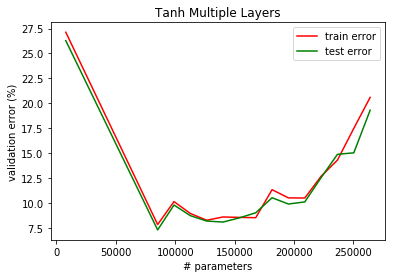

In [8]:
print('parameter list: ', parameters)
print('train_error: ', train_error)
print('test_error: ', test_error)
plot_loss(parameters, train_error, test_error)

In [ ]:
# sigmoid:

In [3]:
n = 15 # number of test
for i in range(n):
    model = tf.keras.Sequential([])
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))
    for j in range(i):
        model.add(tf.keras.layers.Dense(100, activation='sigmoid'))
    for k in range(i):
        model.add(tf.keras.layers.Dense(60, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    parameters.append(model.count_params())  #count parameters for you

    model.compile(optimizer=tf.train.AdamOptimizer(0.001),
                  loss='categorical_crossentropy', #10 classes for output
                  metrics=['accuracy']) # add mae: mean average error
    model.summary()
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3)
    hist = model.fit(X_train, y_train,
                         batch_size=64,
                         epochs=15,
                         verbose=1,
                         validation_data=(X_val, y_val),
                         callbacks=[early_stop])
    train_error.append(100*(1-max(hist.history['acc'])))
    print('train_error: ', train_error)
    test_error.append(100*(1-max(hist.history['val_acc'])))
    print('test_error: ', test_error)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 2s 36us/step - loss: 6.4291 - acc: 0.5940 - val_loss: 4.7547 - val_acc: 0.7009
Epoch 2/15
60000/60000 [==============================] - 2s 28us/step - loss: 4.6242 - acc: 0.7087 - val_loss: 4.5674 - val_acc: 0.7120
Epoch 3/15
60000/60000 [==============================] - 2s 28us/step - loss: 4.4715 - acc: 0.7193 - val_loss: 4.3090 - val_acc: 0.7297
Epoch 4/15
60000/60000 [==============================] - 2s 28us/step - lo

60000/60000 [==============================] - 3s 47us/step - loss: 0.2590 - acc: 0.9200 - val_loss: 0.2548 - val_acc: 0.9207
Epoch 11/15
60000/60000 [==============================] - 3s 48us/step - loss: 0.2465 - acc: 0.9235 - val_loss: 0.2515 - val_acc: 0.9268
Epoch 12/15
60000/60000 [==============================] - 3s 46us/step - loss: 0.2410 - acc: 0.9256 - val_loss: 0.2348 - val_acc: 0.9300
Epoch 13/15
60000/60000 [==============================] - 3s 48us/step - loss: 0.2350 - acc: 0.9270 - val_loss: 0.2305 - val_acc: 0.9294
Epoch 14/15
60000/60000 [==============================] - 3s 47us/step - loss: 0.2355 - acc: 0.9257 - val_loss: 0.2630 - val_acc: 0.9169
Epoch 15/15
60000/60000 [==============================] - 3s 47us/step - loss: 0.2285 - acc: 0.9297 - val_loss: 0.2434 - val_acc: 0.9275
train_error:  [26.25666666666666, 6.691666666666663, 7.033333333333336]
test_error:  [25.670000000000005, 6.020000000000003, 6.999999999999995]
________________________________________

60000/60000 [==============================] - 4s 64us/step - loss: 0.3453 - acc: 0.9002 - val_loss: 0.3292 - val_acc: 0.9079
Epoch 15/15
60000/60000 [==============================] - 4s 64us/step - loss: 0.3314 - acc: 0.9057 - val_loss: 0.3168 - val_acc: 0.9096
train_error:  [26.25666666666666, 6.691666666666663, 7.033333333333336, 7.956666666666667, 9.431666666666672]
test_error:  [25.670000000000005, 6.020000000000003, 6.999999999999995, 7.689999999999997, 9.040000000000003]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_26 (Dense)             (None, 100)               10100     
______________________________________________________

60000/60000 [==============================] - 5s 89us/step - loss: 0.8308 - acc: 0.7359 - val_loss: 0.7220 - val_acc: 0.7768
Epoch 10/15
60000/60000 [==============================] - 5s 89us/step - loss: 0.7716 - acc: 0.7615 - val_loss: 0.7897 - val_acc: 0.7264
Epoch 11/15
60000/60000 [==============================] - 5s 86us/step - loss: 0.7500 - acc: 0.7789 - val_loss: 0.7271 - val_acc: 0.7928
Epoch 12/15
60000/60000 [==============================] - 5s 80us/step - loss: 0.7235 - acc: 0.7902 - val_loss: 0.6717 - val_acc: 0.8132
Epoch 13/15
60000/60000 [==============================] - 5s 82us/step - loss: 0.6742 - acc: 0.8115 - val_loss: 0.6760 - val_acc: 0.8133
Epoch 14/15
60000/60000 [==============================] - 5s 90us/step - loss: 0.6940 - acc: 0.8027 - val_loss: 0.7006 - val_acc: 0.7925
Epoch 15/15
60000/60000 [==============================] - 5s 92us/step - loss: 0.6794 - acc: 0.8105 - val_loss: 0.6244 - val_acc: 0.8290
train_error:  [26.25666666666666, 6.6916666666

Epoch 7/15
60000/60000 [==============================] - 7s 113us/step - loss: 2.3021 - acc: 0.1110 - val_loss: 2.3014 - val_acc: 0.1135
Epoch 8/15
60000/60000 [==============================] - 7s 110us/step - loss: 2.3018 - acc: 0.1120 - val_loss: 2.3014 - val_acc: 0.1135
Epoch 9/15
60000/60000 [==============================] - 6s 103us/step - loss: 2.3016 - acc: 0.1124 - val_loss: 2.3011 - val_acc: 0.1135
train_error:  [26.25666666666666, 6.691666666666663, 7.033333333333336, 7.956666666666667, 9.431666666666672, 15.671666666666662, 18.845, 89.33833333333332, 88.76333333333332]
test_error:  [25.670000000000005, 6.020000000000003, 6.999999999999995, 7.689999999999997, 9.040000000000003, 14.139999999999997, 17.100000000000005, 88.64999999999999, 88.64999999999999]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
________________________

60000/60000 [==============================] - 9s 145us/step - loss: 2.3047 - acc: 0.1075 - val_loss: 2.3035 - val_acc: 0.0980
Epoch 3/15
60000/60000 [==============================] - 9s 143us/step - loss: 2.3045 - acc: 0.1073 - val_loss: 2.3038 - val_acc: 0.1009
Epoch 4/15
60000/60000 [==============================] - 8s 140us/step - loss: 2.3035 - acc: 0.1072 - val_loss: 2.3031 - val_acc: 0.1135
Epoch 5/15
60000/60000 [==============================] - 8s 138us/step - loss: 2.3036 - acc: 0.1072 - val_loss: 2.3029 - val_acc: 0.1032
train_error:  [26.25666666666666, 6.691666666666663, 7.033333333333336, 7.956666666666667, 9.431666666666672, 15.671666666666662, 18.845, 89.33833333333332, 88.76333333333332, 89.3, 89.24833333333333]
test_error:  [25.670000000000005, 6.020000000000003, 6.999999999999995, 7.689999999999997, 9.040000000000003, 14.139999999999997, 17.100000000000005, 88.64999999999999, 88.64999999999999, 88.64999999999999, 88.64999999999999]
________________________________

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 15s 242us/step - loss: 2.3066 - acc: 0.1050 - val_loss: 2.3025 - val_acc: 0.1135
Epoch 2/15
60000/60000 [==============================] - 10s 172us/step - loss: 2.3049 - acc: 0.1056 - val_loss: 2.3027 - val_acc: 0.1135
Epoch 3/15
60000/60000 [==============================] - 10s 165us/step - loss: 2.3047 - acc: 0.1070 - val_loss: 2.3044 - val_acc: 0.0980
Epoch 4/15
60000/60000 [==============================] - 10s 166us/step - loss: 2.3041 - acc: 0.1049 - val_loss: 2.3023 - val_acc: 0.1135
train_error:  [26.25666666666666, 6.691666666666663, 7.033333333333336, 7.956666666666667, 9.431666666666672, 15.671666666666662, 18.845, 89.33833333333332, 88.76333333333332, 89.3, 89.24833333333333, 89.32166666666667, 89.30333333333334]
test_error:  [25.670000000000005, 6.020000000000003, 6.999999999999995, 7.689999999999997, 9.040000000000003, 14.139999999999997, 17.100000000000005, 88.64

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 17s 290us/step - loss: 2.3077 - acc: 0.1043 - val_loss: 2.3031 - val_acc: 0.1135
Epoch 2/15
60000/60000 [==============================] - 12s 197us/step - loss: 2.3046 - acc: 0.1067 - val_loss: 2.3086 - val_acc: 0.1135
Epoch 3/15
60000/60000 [==============================] - 12s 204us/step - loss: 2.3045 - acc: 0.1067 - val_loss: 2.3027 - val_acc: 0.1135
Epoch 4/15
60000/60000 [==============================] - 12s 206us/step - loss: 2.3040 - acc: 0.1062 - val_loss: 2.3012 - val_acc: 0.1135
Epoch 5/15
60000/60000 [==============================] - 12s 198us/step - loss: 2.3032 - acc: 0.1081 - val_loss: 2.3036 - val_acc: 0.1135
Epoch 6/15
60000/60000 [==============================] - 12s 200us/step - loss: 2.3030 - acc: 0.1067 - val_loss: 2.3028 - val_acc: 0.1135
Epoch 7/15
60000/60000 [==============================] - 12s 193us/step - loss: 2.3023 - acc: 0.1098 - val_loss: 2.

In [4]:
def plot_loss(parameters_list, train_errors_list, test_errors_list):
    ax = plt.subplot(111)
    ax.plot(parameters_list, train_errors_list,'r', label='train error')
    ax.plot(parameters_list, test_errors_list,'g', label='test error')
    ax.set(xlabel='# parameters', ylabel='validation error (%)')
    ax.legend()
    plt.title('Sigmoid Multiple Layers')
    plt.show()

parameter list:  [7850, 85170, 98930, 112690, 126450, 140210, 153970, 167730, 181490, 195250, 209010, 222770, 236530, 250290, 264050]
train_error:  [26.25666666666666, 6.691666666666663, 7.033333333333336, 7.956666666666667, 9.431666666666672, 15.671666666666662, 18.845, 89.33833333333332, 88.76333333333332, 89.3, 89.24833333333333, 89.32166666666667, 89.30333333333334, 89.23333333333333, 89.025]
test_error:  [25.670000000000005, 6.020000000000003, 6.999999999999995, 7.689999999999997, 9.040000000000003, 14.139999999999997, 17.100000000000005, 88.64999999999999, 88.64999999999999, 88.64999999999999, 88.64999999999999, 88.64999999999999, 88.64999999999999, 88.64999999999999, 88.64999999999999]


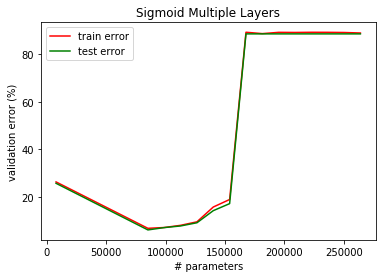

In [5]:
print('parameter list: ', parameters)
print('train_error: ', train_error)
print('test_error: ', test_error)
plot_loss(parameters, train_error, test_error)

# Part 3. VGG on CIFAR100 and CIFAR10

VGG is a simple, but powerful CNN created in 2015. Read the VGG paper here: https://arxiv.org/pdf/1409.1556.pdf

Here, we're going to try to reproduce the model's findings on the cifar10 and cifar100 dataset. Note that the paper takes 224 x 224 images, but cifar10 and 100 are only 32 x 32 images.

1. Implement all of the layers for the VGG ConvNet Configuration A. Please use the shell code below as guide. Then, train this network on the Cifar10 and Cifar100 datasets.
2. For Cifar10 and 100, VGG is probably overkill. Try changing the number of layers and number of filters without sacrificing too much performance accuracy. How many filters can you get rid of before you see the accuracy drop by more than 2%? Where in the architecture is it better to remove filters - towards the input layers, or more towards the output layers?
3. For what you experiment with--report the parameter, validation loss curves for changing the number of i) layers, ii) filter size, iii) both.

Training data shape (50000, 32, 32, 3)


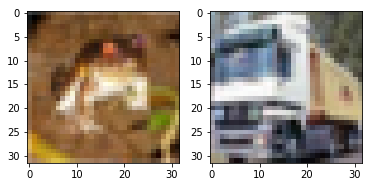

In [2]:
# This is the same model in the other notebook, looks very simplified.
import tensorflow as tf
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.cifar10.load_data() #32*32 RGB vectors
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)

X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(32, 32, 3));
ax2.imshow(X_train[1].reshape(32, 32, 3));

In [3]:
# Example CNN used in class
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(padding='same'),
    
    tf.keras.layers.Conv2D(128, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),
    
    tf.keras.layers.Conv2D(256, (5,5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),
    

    tf.keras.layers.Conv2D(512, (5,5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),
    
    tf.keras.layers.Conv2D(512, (5,5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.train.AdamOptimizer(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         1638656   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
__________

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3)
hist = model.fit(X_train, y_train,
                 batch_size=64,
                 epochs=5,
                 verbose=1,
                 validation_data=(X_val, y_val),
                 callbacks=[early_stop])

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
  512/50000 [..............................] - ETA: 1:06:17 - loss: 2.3181 - acc: 0.0840

KeyboardInterrupt: 

# (Optional) Part 4, state of the art

Currently, state of the art implementations in the image classification problem are DenseNet: (https://arxiv.org/abs/1608.06993), ResNet (https://arxiv.org/abs/1512.03385), and ResNext (https://arxiv.org/pdf/1611.05431.pdf). Try implementing and training one of these on the cifar10 and cifar100 dataset. Feel free to experiment.

Jargon to learn about
1. What is "residual learning"?


2. What is a "bottleneck layer"?


3. What is a "dense block"?